# Scanpy ile Tek Hücre RNA Sekans Analiz Rehberi 📒🖋️

👩🏼‍💻 **_Elif Duymaz Yılmaz, MSc._**

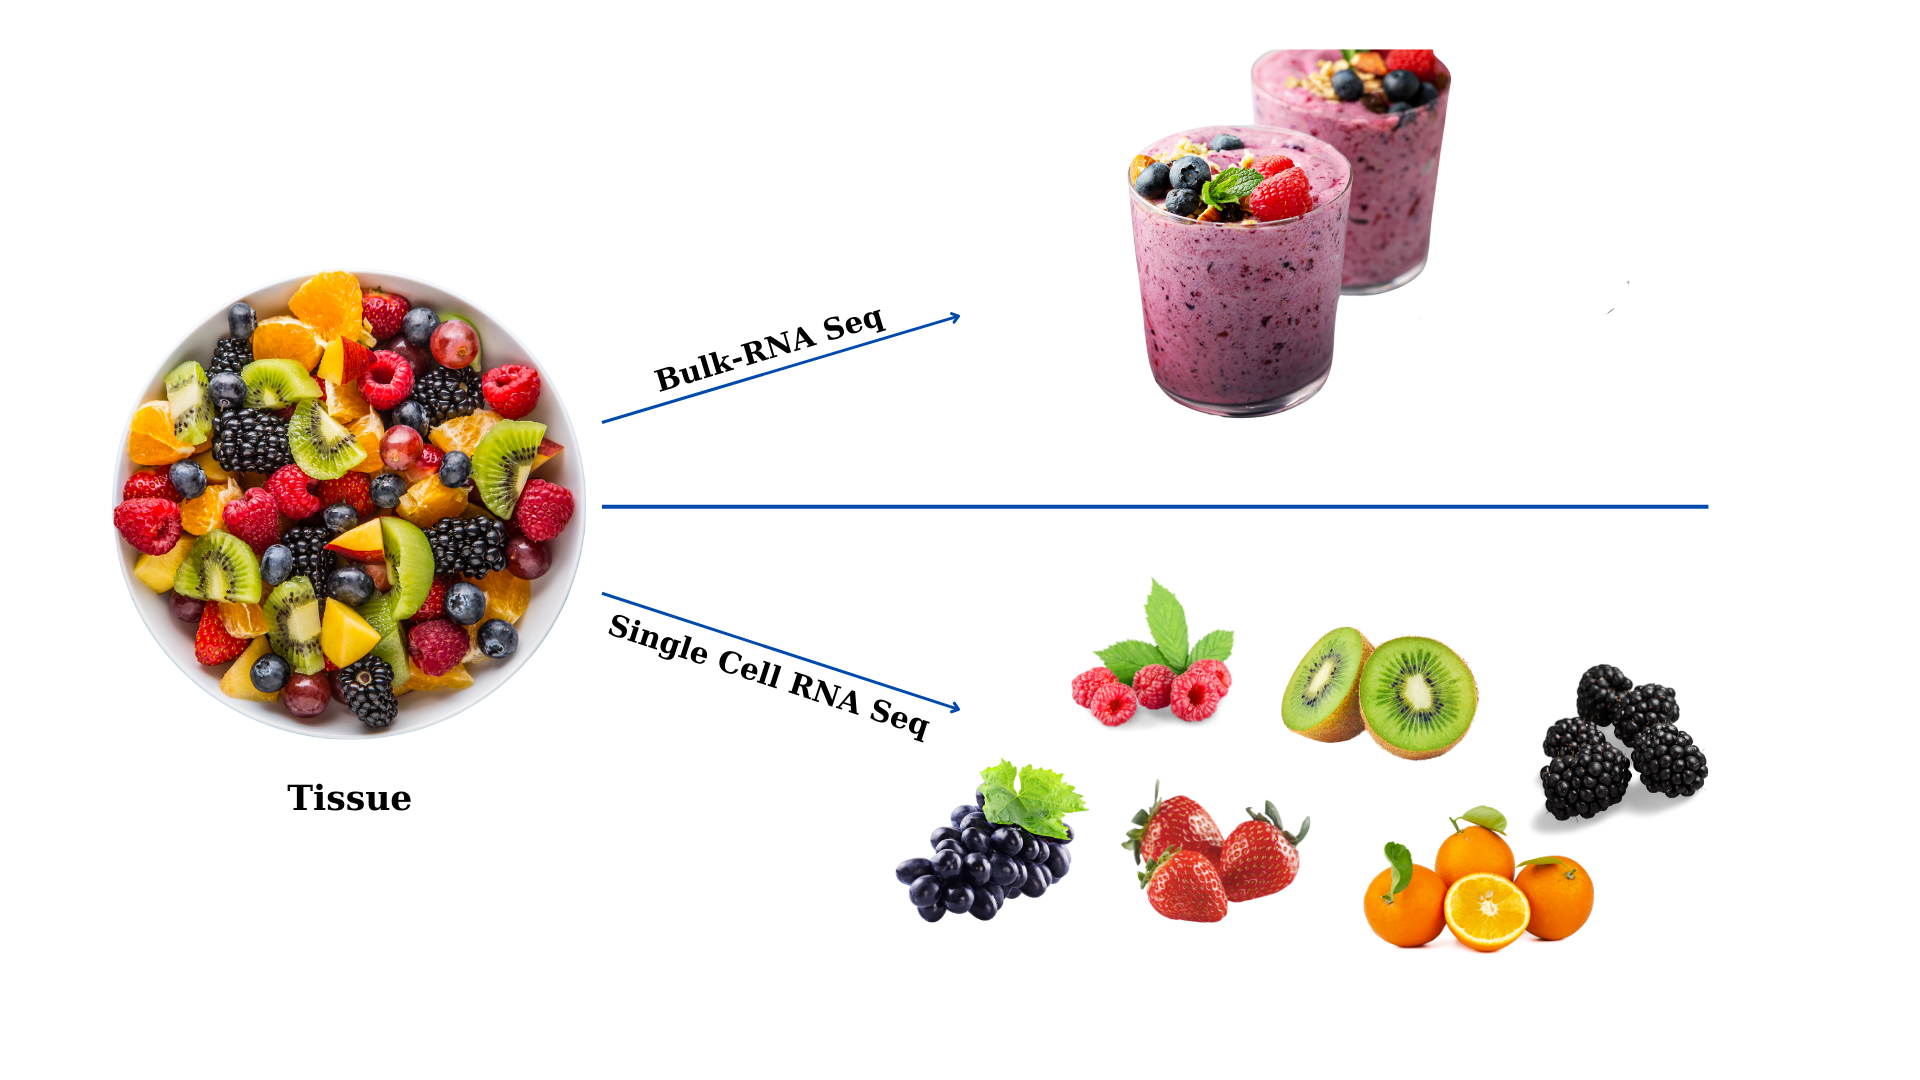

In [2]:
from IPython.display import Image
Image("SinglecellRNA Seq.png")

 **Şekil 1.** Bulk-RNA ve scRNA sekanslama arasındaki fark. 
 (Görsel [Steinheuer ve ark. 2021](https://doi.org/10.1101/2021.04.02.438193) makalesinden esinlenerek oluşturulmuştur.)

Aşağıdaki kodları çalıştırmak için hazırlanmış olan çalışma ortamına docker image olarak [**DockerHub**](https://hub.docker.com/r/elifduymaz/singlecell-workspace) adresinden erişebilirsiniz. 
Aşağıdaki işlemlerin yapılabilmesi için bilgisayarınızda Docker'ın kurulu olması gerekmektedir; eğer Docker kurulu değilse, [Docker website](https://www.docker.com/) adresindeki kurulum adımlarını, cihazınızın gerekliliklerine göre oluşturabilirsiniz. Daha fazla bilgi edinmek için [Docker dokümantasyonunu](https://docker-curriculum.com/) inceleyebilirsiniz.

#### ⏬ Dockerfile İndirme & Çalışma Ortamı Hazırlık 

In [ ]:
docker pull elifduymaz/singlecell-workspace

In [ ]:
docker run -p 8888:8888 elifduymaz/singlecell-workspace

<div style="border: 1px solid red; background-color: #f8d7da; padding: 10px; margin: 10px 0; border-radius: 5px;">
<b>🔔 📝 Önemli!</b> Yukarıdaki işlemleri terminalinizde çalıştırmalısınız, ardından internet tarayıcınızda 
<b>'http://localhost:8888/'</b> adresinin yazması gerekmektedir.
</div>


<div style="border: 1px solid orange; background-color: #fff3e6; padding: 10px; margin: 10px 0; border-radius: 5px;">
<b>🔖 Uyarı:</b> Bu rehber içerik tek hücre RNA sekanslama (scRNA seq) analizleri için hazırlanmıştır. 
Temel düzeyde Python ve Linux bilgisi gerekmektedir. Aşağıdaki komutların bir kısmı Linux sisteminde devamı ise Python dilinde çalıştırılmak üzere yazılmıştır.
</div>


#### ⏬ Data İndirme

**fastq-dump**, **[SRA Toolkit](https://github.com/ncbi/sra-tools/wiki/02.-Installing-SRA-Toolkit)** içerisinde yer alan bir araçtır. Link içerisinde yer alan gerekli adımları yerine getirerek sisteminize uygun biçimde kurmalısınız; ardından SRR verilerinin ham (`.fastq.gz`) formunu çalışacağınız dizine indirebilirsiniz.

In [ ]:
fastq-dump SRRXXXXXX

<div style="border: 2px dashed #0000FF; background-color: #e6f0ff; padding: 15px; margin: 10px 0; border-radius: 10px;">
<b>🦉 Bilgi:</b> Bu rehber içerik için; PBMC veri kümesi kullanılmıştır. Detaylı bilgi için inceleyebilirsiniz ⏩
    <a href="https://www.10xgenomics.com/datasets/3-k-pbm-cs-from-a-healthy-donor-1-standard-1-1-0" target="_blank" style="color: #0000FF; text-decoration: underline;">PBMC3k</a>.
</div>

🔹 **wget** `https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_fastqs.tar`

``` markdown
Peripheral blood mononuclear cells (PBMCs) from a healthy donor (same donor as pbmc6k).
PBMCs are primary cells with relatively small amounts of RNA (~1pg RNA/cell).

- 2,700 cells detected
- Sequenced on Illumina NextSeq 500 with ~69,000 reads per cell
- 98bp read1 (transcript), 8bp I5 sample barcode, 14bp I7 GemCode barcode and 10bp read2 (UMI)
- Analysis run with --cells=3000
```

### 🔻 1. Verinin İşlenmesi ve Sayımları (FASTQ ➡️ Count Matrix)

FASTQ dosyaları, ham dizilim verilerini içeren ve biyoinformatik analizlerin temelini oluşturan veri formatlarıdır. Gen ifadesi analizi gerçekleştirebilmek için, bu ham verilerin işlenerek gen ifadesi sayımlarına dönüştürülmesi gerekir. Bu işlem sırasında, her bir hücrede bulunan her bir gen için dizilenen transkriptlerin sayısı belirlenir.

``` markdown
@SEQ_ID              # okumanın kimliği ile ilgili bilgiler

ATGGGTTGTCATTTAC     # okumanın nükleotid dizisi

'+'                  # Bilgi de içerebilir veya sadece + şeklinde kullanılır

IIIIIIIII            # Her bir nükleotid için dizileme kalitesini temsil edene ASCII karakterleridir      
```

<div style="border: 1px solid #4CAF50; background-color: #f9f9f9; padding: 10px; margin: 10px 0; border-radius: 5px;">
<b>Tek hücre RNA dizileme (scRNA-seq) verilerinin işlenmesi ve gen ifadesi matrislerinin oluşturulması için çeşitli araçlar kullanılmaktadır. Aşağıda, en yaygın kullanılan araçlar ve özellikleri sıralanmıştır:</b> 

- **[Cell Ranger](https://www.10xgenomics.com/support/software/cell-ranger/latest) (10x Genomics):**
10x Genomics platformu tarafından sağlanan verilerin analizinde yaygın olarak tercih edilir. Cell Ranger, dizilim verilerini alarak referans genomla hizalama yapar, gen ifadesi matrisini oluşturur ve sonuçları matrix.mtx formatında sağlar. Bu araç, platformla entegre çalışacak şekilde optimize edilmiştir ve kapsamlı bir iş akışı sunar.

- **[STARsolo](https://github.com/alexdobin/STAR/blob/master/docs/STARsolo.md):**
Popüler STAR hizalayıcısının tek hücre RNA-seq verileri için özelleştirilmiş versiyonudur. STARsolo, yüksek hassasiyet ve hız sunarak verileri referans genomla hizalar ve gen ifadesi matrisini üretir. Özellikle büyük veri setleriyle çalışırken performansı ile öne çıkar.

- **[Kallisto & BUStools](https://pachterlab.github.io/kallistobustools/tutorials/kb_getting_started/R/kb_intro_2_R/ ):**
Pseudo-hizalama (pseudo-alignment) tabanlı bir yaklaşım sunan Kallisto & BUStools, hızlı ve hafif bir alternatif olarak dikkat çeker. Bu araçlar, referans bir genom yerine transkript seviyesinde çalışarak gen ifadesi sayım matrisini oluşturur ve hesaplama verimliliği açısından avantaj sağlar.
</div>

``` markdown
cellranger count --id=sample_name \
                 --transcriptome=/path/to/refdata-gex-GRCh38-2020-A \
                 --fastqs=/path/to/fastq_directory \
                 --sample=sample_name
```

<div style="border: 1px solid red; background-color: #f8d7da; padding: 10px; margin: 10px 0; border-radius: 5px;">
<b>🔔 📝 Önemli!</b> Büyük boyutlu verilerin işlenmesi, genellikle yüksek bilgisayar gücü ve performansı gerektirir. Elimizdeki veri seti 18 GB boyutunda olup, bu boyutta bir veriyle çalışabilmek için belirli bir sistem kapasitesine ihtiyaç duyulmaktadır.
</div>


**Bu sebeple, alternatif bir seçenek olması için yüksek işlem gücüne ihtiyaç duymadan aşağıdaki komutları kullanarak  işlenmiş sonuçları hazır halde kullanabilirsiniz.**

In [ ]:
!mkdir -p data
!curl https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir -p write

### 🔻 2. Sayım Matrisini Anndata Formatına Çevirme (Count Matrix ➡️ Anndata)
Cell Ranger veya STARsolo gibi araçlardan elde edilen sayım matrisleri genellikle `matrix.mtx`, `features.tsv` ve `barcodes.tsv` dosyalarını içerir. Bu dosyaları `.h5ad` formatına dönüştürmek için `scanpy` kullanabiliriz.

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

##### 🔹 **Sayım matrisini yükleme**

In [2]:
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19/',  
    var_names='gene_symbols',        
    cache=True
)

In [3]:
adata.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 2286884 stored elements and shape (2700, 32738)>

##### 🔹 **Veriyi `.h5ad` olarak kaydetme**

In [4]:
adata.write('./data/pbmc3k_adata.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

Bu aşamada, her bir hücredeki gen ekspresyon sayımlarını içeren Anndata nesnesini oluşturuyoruz. **`.h5ad`** formatı, sayım verileri ile birlikte hücre ve genlere ait ek bilgileri de tutabileceği için çok yönlüdür ve daha hızlı bir analiz sağlar.

### 🔻 3. Hücre ve Gen Bilgilerini Eklemek (Metadata Entegrasyonu)

`.h5ad` formatı, hücre veya genlere ilişkin ek bilgileri eklemek için de uygundur. Bu aşamada AnnData nesnesine hücre ve gen özelliklerini (örneğin, hücrelerin koşulları, hücre türleri veya kalite metrikleri) ekleyebilirsiniz.

``` markdown
adata.obs['condition'] = ['control', 'treated', ...]  # Hücre bilgisi ekleme
adata.var['gene_length'] = [1000, 2000, ...]          # Gen bilgisi ekleme
```

``` markdown
adata.write('pbmc3k_adata_version2.h5ad')  # bulunduğunuz dizine kaydetme işlemi
```

Bu kısma kadar işlenen adımları rehberimiz için direkt kullanabileceğiz, siz dilerseniz oluşturduğunuz obje üzerinde işlemlerinize devam edebilirsiniz.
Bu durumda `Anndata` objesinin bulunduğu dizinden okuma yapmanız gerektiğinde:

```markdown
adata = sc.read_h5ad("/path/pbmc3k_adata_version2.h5ad")    # 'path' kısmına dosyanın bulunduğu dizin verilmelidir.
```

## Ön İşlemler

Tüm hücreler genelinde, her bir hücrede en yüksek sayım oranını veren genleri şu şekilde görselleyebiliriz. Bu görsel, ham verideki anormallikleri veya beklenmedik paternleri hızlıca fark etmenize yardımcı olabilir. (Opsiyonel)

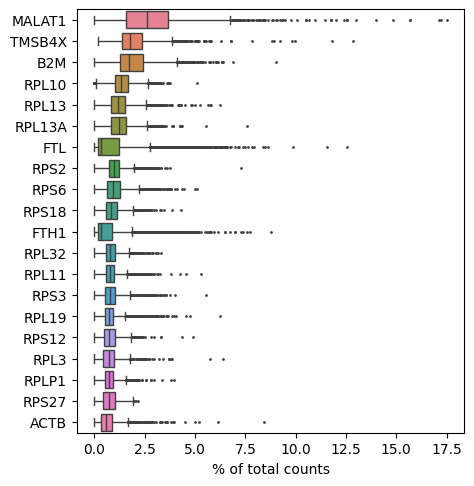

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [7]:
adata.n_vars

32738

In [8]:
adata.n_obs

2700

In [9]:
sc.pp.filter_cells(adata, min_genes=200)  #toDo
sc.pp.filter_genes(adata, min_cells=3)   #toDo

In [10]:
adata.n_obs

2700

In [11]:
adata.n_vars

13714

**19024 gen**, **3 hücreden** daha azında tespit edildiği için filtrelendi.

### 🔻 4. Veri Kalitesinin Değerlendirilmesi ve Mitochondrial Filtreleme

🔹 **Hücre kalitesini değerlendirirken, düşük kaliteli hücrelerin filtrelenmesi önemlidir. Özellikle mitokondriyal genlerin yüksek ekspresyon oranına sahip hücreler bu kapsamda değerlendirilmelidir.**

Yüksek orandaki mitokondriyal gen ekspresyonu, genellikle düşük kaliteli hücreleri işaret etmektedir; bu durum, hücre zarından delinen hücrelerde sitoplazmik RNA'nın kaybı nedeniyle olabilir. Bunun nedeni ise mitokondrilerin, bireysel transkript moleküllerinden daha büyük olmaları ve hücre zarı yırtılmalarından daha az etkilenmeleri ihtimalidir. `pp.calculate_qc_metrics` fonksiyonu, bu tür metrikleri verimli bir şekilde hesaplamak için kullanılmaktadır:

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')

sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Hesaplanan bazı kalite ölçütlerinin violin grafiği:

- Sayım matrisinde ifade edilen gen sayısı,
- Hücre başına toplam sayım,
- Mitokondriyal genlerdeki sayımların yüzdesi

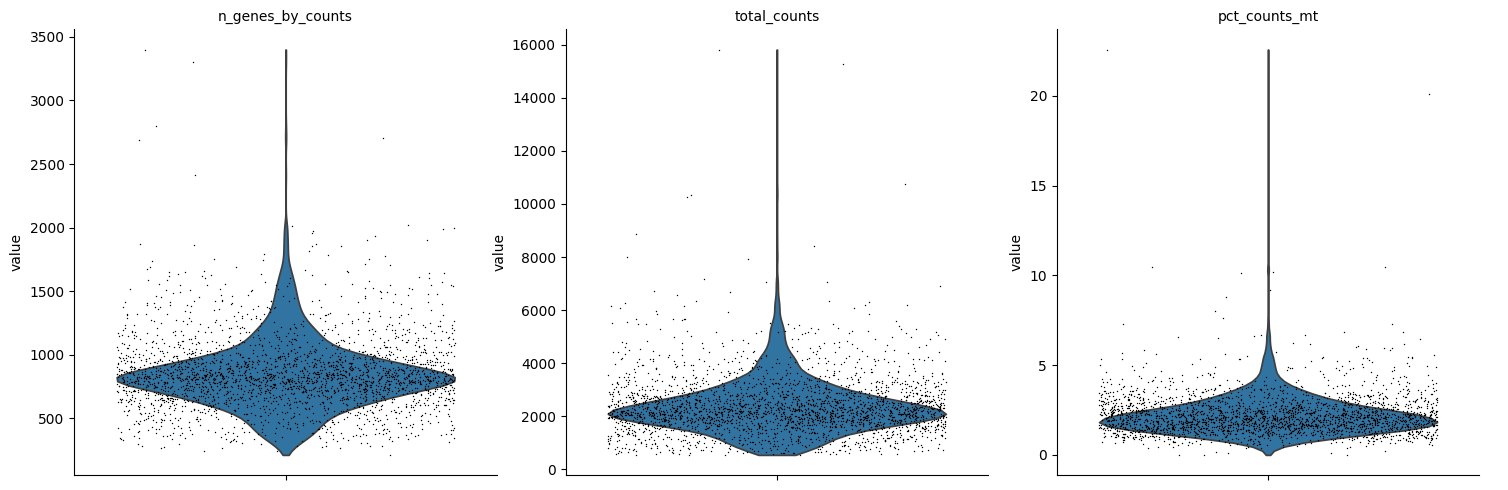

In [13]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Mitokondriyal genlerin aşırı derecede ifade edildiği veya toplam okuma sayısı çok yüksek olan hücreler, kalite kontrol kriterlerine uygun olarak analizden çıkarılmalıdır.

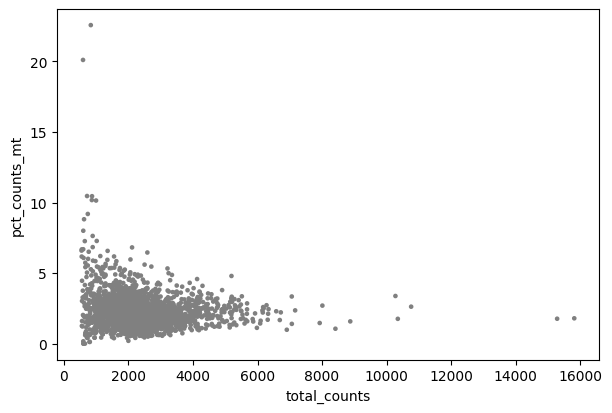

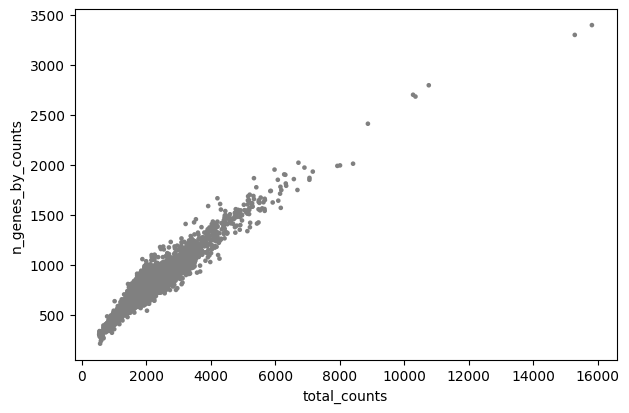

'\nsc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="n_genes_by_counts", color_map=\'Reds\', legend_loc=\'right margin\')\nsc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="n_genes_by_counts", color_map="Reds", legend_loc="right margin")\n'

In [14]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

'''
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="n_genes_by_counts", color_map='Reds', legend_loc='right margin')
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="n_genes_by_counts", color_map="Reds", legend_loc="right margin")
'''

`Anndata` objesinin tablolarını bölerek filtreleyebiliriz.

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

Toplam sayım veri matrisini hücre başına 10.000 okumaya normalleştirerek (kütüphane boyutuna göre ölçeklendirme yaparak), hücreler arasındaki biyolojik varyasyonları doğru bir şekilde değerlendirmek amacıyla sayımların karşılaştırılabilir hale gelmesini sağlamalıyız. Bu işlem, farklı hücrelerdeki toplam sayım farklılıklarının, teknik varyasyondan ziyade biyolojik değişikliklere dayalı olarak analiz edilmesine olanak tanır.

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

Gen ekspresyon verisi gibi sayısal verilerde, verinin dağılımını daha düzgün hale getirmek ve büyük değere sahip uç noktaları (outliers) daha yönetilebilir bir aralığa indirmek için veri logaritmize edilmelidir.

In [17]:
sc.pp.log1p(adata)

Biyolojik olarak anlamlı varyasyonları ve hücreler arasında farklılaşmayı en iyi şekilde temsil eden genleri belirlemek önemlidir. Bu genler, genellikle hücresel farklılaşma, hücre tipleri arasındaki farklar veya yanıtlar gibi biyolojik süreçlerin daha iyi anlaşılmasını sağlar.

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

'''
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
'''

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'\nsc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)\nadata = adata[:, adata.var.highly_variable]\n'

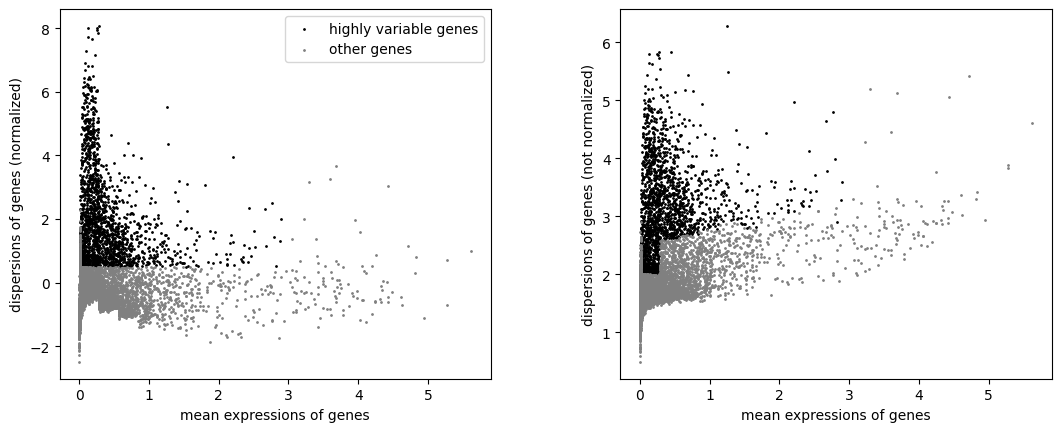

In [19]:
sc.pl.highly_variable_genes(adata)

`AnnData` objesininin `.raw` özniteliğini, ileride diferansiyel testler ve gen ekspresyonu görselleştirmelerinde kullanılmak üzere normalize edilmiş ve logaritmik dönüşüm uygulanmış ham gen ekspresyon verileriyle güncelliyoruz. 

🔹 Bu işlem, `AnnData` objesinin mevcut durumunu sabitlemek için kullanılmıştır. Veriler üzerinde normalizasyon veya başka bir işlem yaptıktan sonra orijinal verilere dönmek isterseniz, `.raw.to_adata()` metodunu kullanabilirsiniz.

In [20]:
adata.raw = adata

##### Burada; biyolojik olarak anlamlı varyasyonları tespit etmek için yüksek değişkenlik gösteren genleri (sabit veya az ifade düzeyine sahip) analizden çıkarmalıyız.

In [21]:
adata = adata[:, adata.var.highly_variable]

Toplam hücre başına düşen RNA sayısı `(total_counts)` ve mitokondriyal genlerin yüzdesi `(pct_counts_mt)` gibi teknik veya biyolojik etkilerin ifade verilerinden çıkarmak için **regresyon** işlemi yapılmaktadır. 

In [22]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

Bu işlemde, tüm gen ifadelerini normalize ederek birim varyansa (unit variance) ölçeklenir. Normalizasyon ve standardizasyon, gen ifadeleri arasındaki farklı ölçüm ölçeklerini uyumlu hale getirir. Eğer bir genin standardize edilmiş z-score değeri 10'u aşarsa, bu değer 10 ile sınırlanır (clip edilir). Bu, aşırı uçların etkisini azaltır ve daha dengeli bir analiz sağlar.

In [23]:
sc.pp.scale(adata, max_value=10)

## Analizler ve Grafikler

### 🔻 5. Temel Bileşen Analizi (Principal Component Analysis)

Temel bileşen analizi *(PCA)* ([Pedregosa et al., 2011](https://dl.acm.org/doi/10.5555/1953048.2078195)) yüksek boyutlu verilerdeki temel varyasyon eksenlerini belirlemek ve veriyi daha düşük boyutlara indirgemek için kullanılan istatistiksel bir yöntemdir.
Bu yöntem, biyolojik sinyalleri korurken teknik gürültüyü azaltır. `sc.tl.pca` fonksiyonu, PCA'yı gerçekleştirir ve `svd_solver="arpack"` parametresi, büyük veri setleri için optimize edilmiş bir matematiksel algoritma kullanır. PCA sonrası, ilk bileşenler analiz için kullanılabilir ve bu bileşenler genellikle hücresel tipler veya diğer biyolojik varyasyonları yansıtır.

In [24]:
sc.tl.pca(adata, svd_solver="arpack")

⭐ Dilerseniz PC1 içerisindeki top 10 gen için görselleştirme yapabilirsiniz. # Opsiyonel

In [25]:
pc1_loadings = adata.varm['PCs'][:, 0]  # PC1'in yükleri
genes = adata.var_names
pc1_genes = pd.DataFrame({'genes': genes, 'loadings': pc1_loadings})
top_pc1_genes = pc1_genes.sort_values('loadings', ascending=False).head(10)
print(top_pc1_genes)


       genes  loadings
1583    CST3  0.157474
1700  TYROBP  0.146447
894     FCN1  0.146411
588     LST1  0.145450
590     AIF1  0.145025
119   S100A8  0.143476
1818    TYMP  0.138734
1795  LGALS2  0.137575
145   FCER1G  0.133048
1797  LGALS1  0.129566


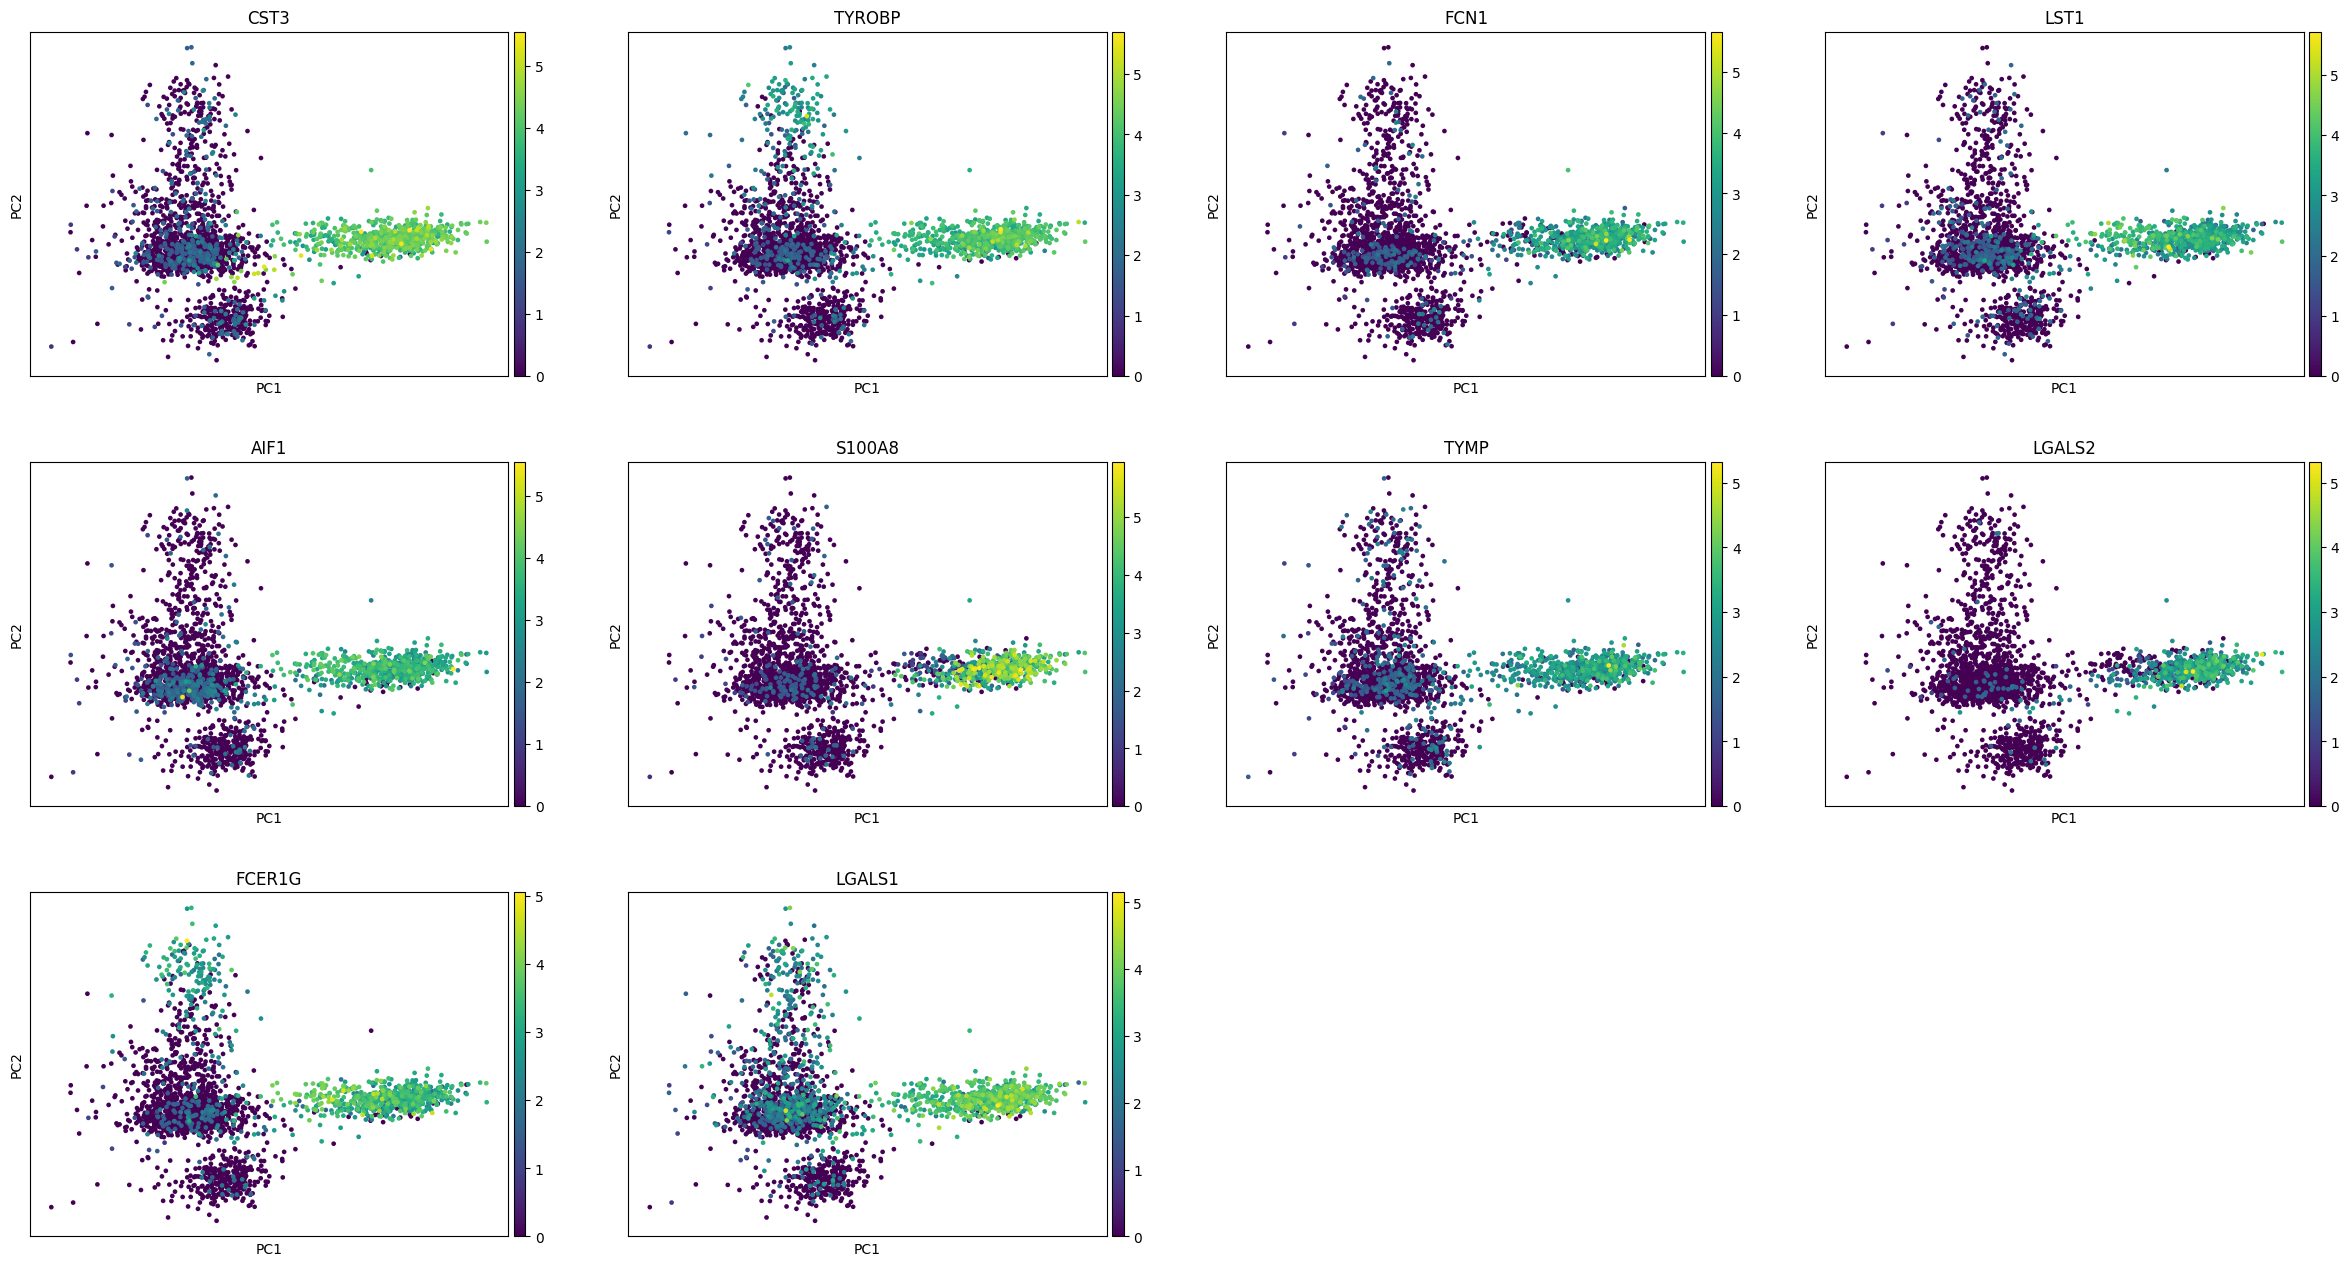

In [26]:
sc.pl.pca(adata, color=top_pc1_genes['genes'])

🔹 PCA, verinin boyutunu azaltırken, en fazla varyasyonu açıklayan bileşenleri (PC'ler) sıralar. Her bir PCA bileşeni, veri setindeki belirli varyasyonları temsil eder ve bazı bileşenler, diğerlerinden daha fazla bilgi taşır. Bu nedenle, PCA bileşenlerinin varyansa katkısını incelemek, hangi bileşenlerin analize dahil edilmesi gerektiğini anlamada kritik bir adımdır.

#### Elbow Grafiği

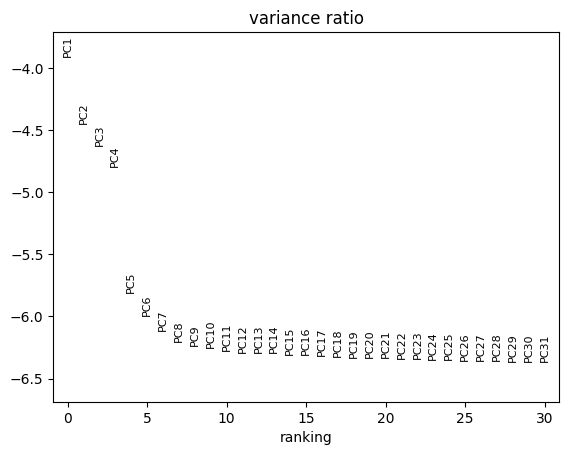

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)

In [28]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
adata.write("./results_file") #'path' kısmına çalıştığınız dizin verilmelidir.

### 🔻 6. Komşuluk Grafiğinin Hesaplanması (Computing)

Komşuluk grafiği, hücreler arasındaki mesafeleri ve bağlantıları tanımlayan bir matematiksel yapı oluşturur. Bu yapı, hücrelerin gruplar halinde (örneğin, kümelenme için) nasıl organize olduğunu anlamamızda kritik bir rol oynar.

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

### 🔻 7. Komşuluk Grafiğinin Düşük Boyutlu Düzleme Yerleştirilmesi (Embedding)

UMAP [(McInnes et al., 2018),](https://arxiv.org/abs/1802.03426) yüksek boyutlu veriyi düşük boyutlu bir düzleme indirgemek için kullanılan bir algoritmadır ve amacı, benzer hücreleri veya veri noktalarını birbirine yakın yerlerde gruplayarak verinin yerel yapısını korumaktır. Ancak, UMAP ve tSNE gibi teknikler yerel ilişkileri iyi korurken, küresel yapıyı her zaman doğru şekilde yansıtamayabilir. Bu nedenle, görselleştirme araçları, verinin genel yapısını anlamak için faydalıdır ancak biyolojik sonuçlar çıkarmadan önce daha fazla analiz gerektirir.

In [32]:
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished (0:00:00)


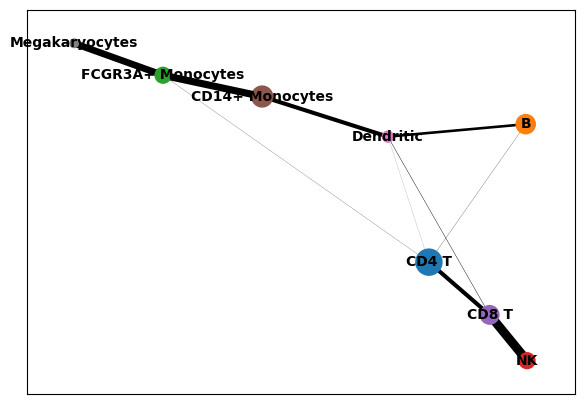

computing UMAP
    finished (0:00:02)


In [56]:
'''
sc.tl.paga(adata)
sc.pl.paga(adata, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
'''

In [33]:
sc.tl.umap(adata)

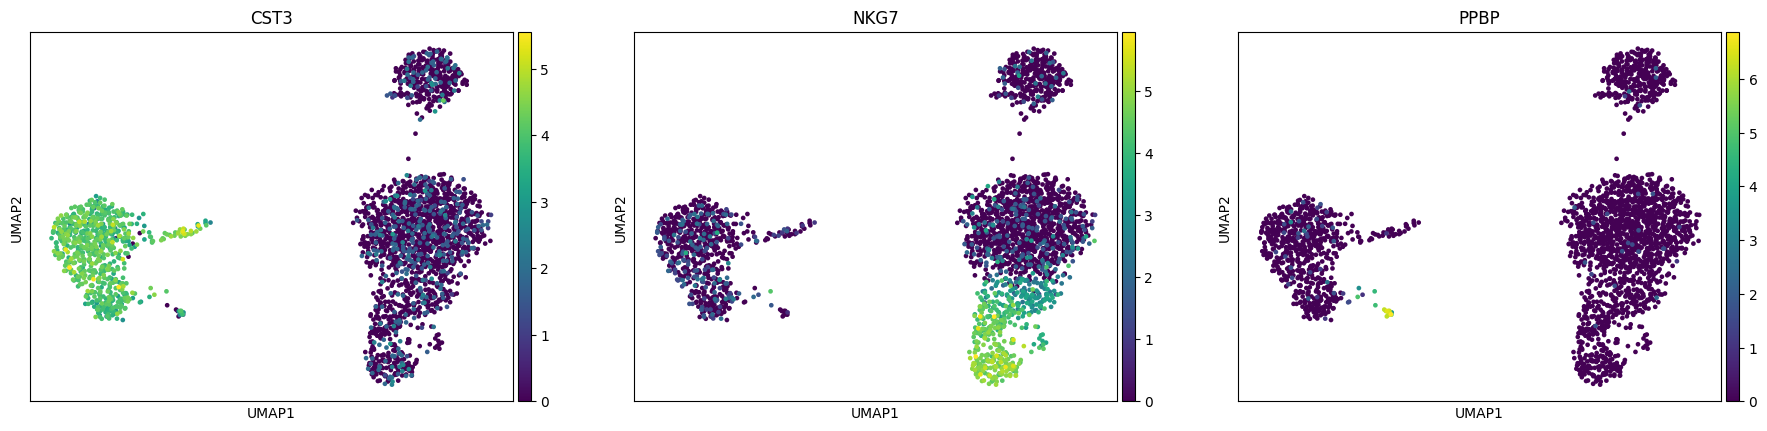

In [34]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

### 🔻 8. Komşuluk Grafiğinin Kümelenmesi

Veri analizi sırasında hücrelerin benzerliklerine göre gruplar oluşturmak amacıyla **Leiden** kümeleme yöntemi kullanılır. Bu, Seurat ve diğer birçok analiz framework'ü tarafından önerilen, modülerliği optimize ederek toplulukları tespit etmeye dayalı bir yaklaşımdır [Traag et al. (2019)](https://www.nature.com/articles/s41598-019-41695-z#Sec2). Leiden kümeleme, hücreler arasındaki ilişkiyi belirlemek için kullandığımız komşuluk grafiğini doğrudan kullanır. Komşuluk grafiği, önceki adımda (komşuluk hesaplama kısmında) zaten hesaplanmıştı.

Leiden kümeleme algoritması, hücreleri modüler yapılarda (topluluklar halinde) gruplayarak, benzer özelliklere sahip hücreleri aynı küme içinde toplar. Bu işlem, özellikle karmaşık biyolojik verilerde hücre popülasyonlarının doğru şekilde sınıflandırılmasında oldukça etkilidir.

In [35]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

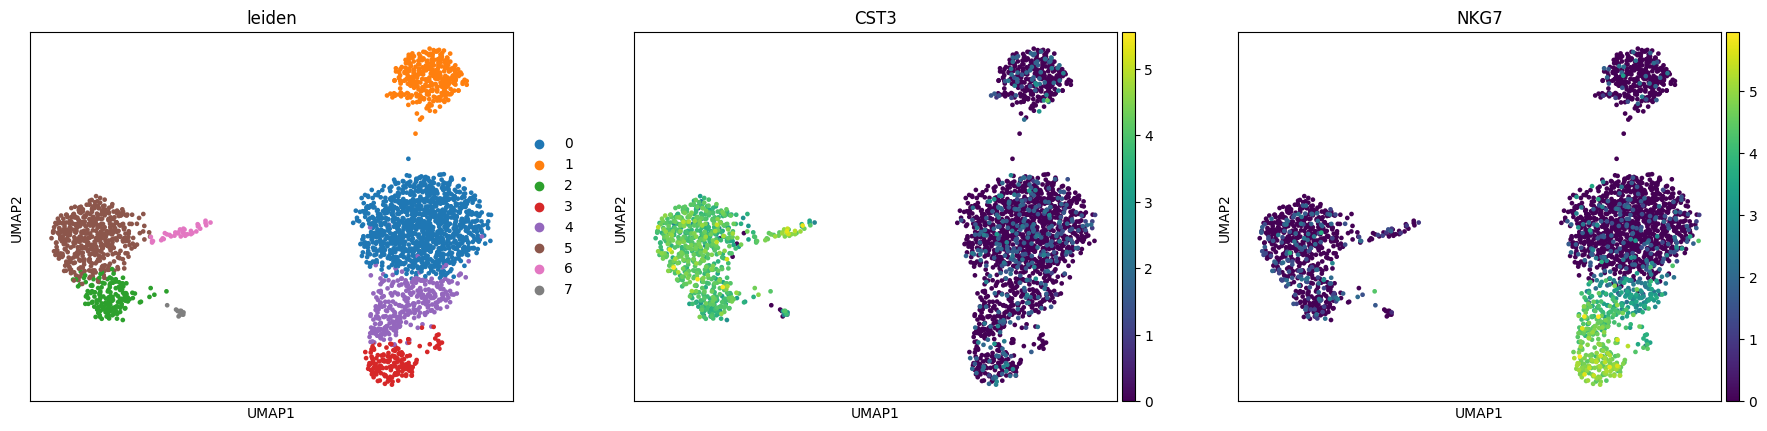

In [36]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

### 🔻 9. Belirteç Genlerin Tespiti (Diferansiyel Gen Ekspresyon Analizi)

Verimizin heterojenliğini yansıtmak amacıyla belirteç genlerin tespiti, biyolojik anlamlılıkları ortaya çıkarmada önemli bir rol oynar. Farklı  istatistiksel yöntemler (örn. `t-test`, `wilcoxon` ve `logreg`) kullanılarak, belirli hücre grupları arasındaki gen ekspresyon farklılıkları incelenebilir. Kullanılacak yöntem; veri türünüze ve analiz amacınıza göre değişiklik gösterebilir.

<div style="border: 2px dashed #0000FF; background-color: #e6f0ff; padding: 15px; margin: 10px 0; border-radius: 10px;">
<b>🦉 Bilgi:</b> Farklı metotlar hakkında bilgi edinmek isteyenler, scRNA dizileme verileri için marker gen seçim yöntemlerinin karşılaştırılması ile ilgili araştırma çalışmasını inceleyebilir
    <a href="https://genomebiology.biomedcentral.com/articles/10.1186/s13059-024-03183-0/tables/1" target="_blank" style="color: #0000FF; text-decoration: underline;">(Pullin&McCarthy, 2024)</a>.
</div>

#### 🔘 T-test Metodu

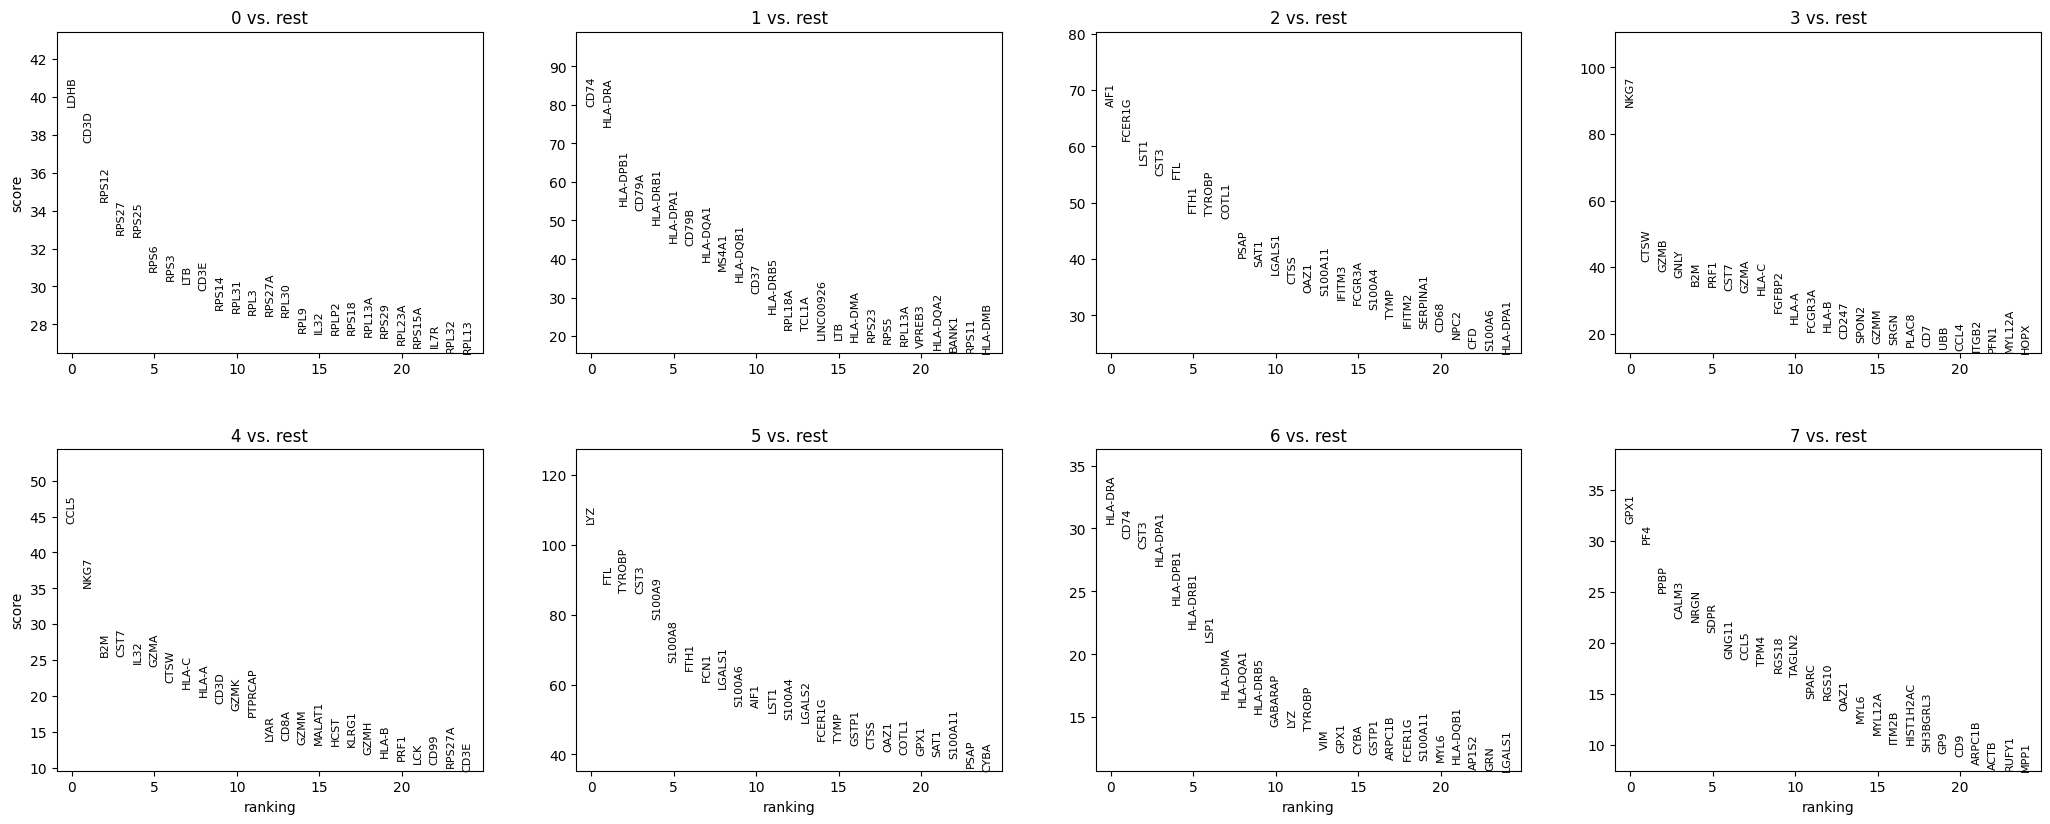

In [37]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [38]:
sc.settings.verbosity = 2  # reduce the verbosity

#### 🔘 Wilcoxon Metodu

ranking genes
    finished (0:00:01)


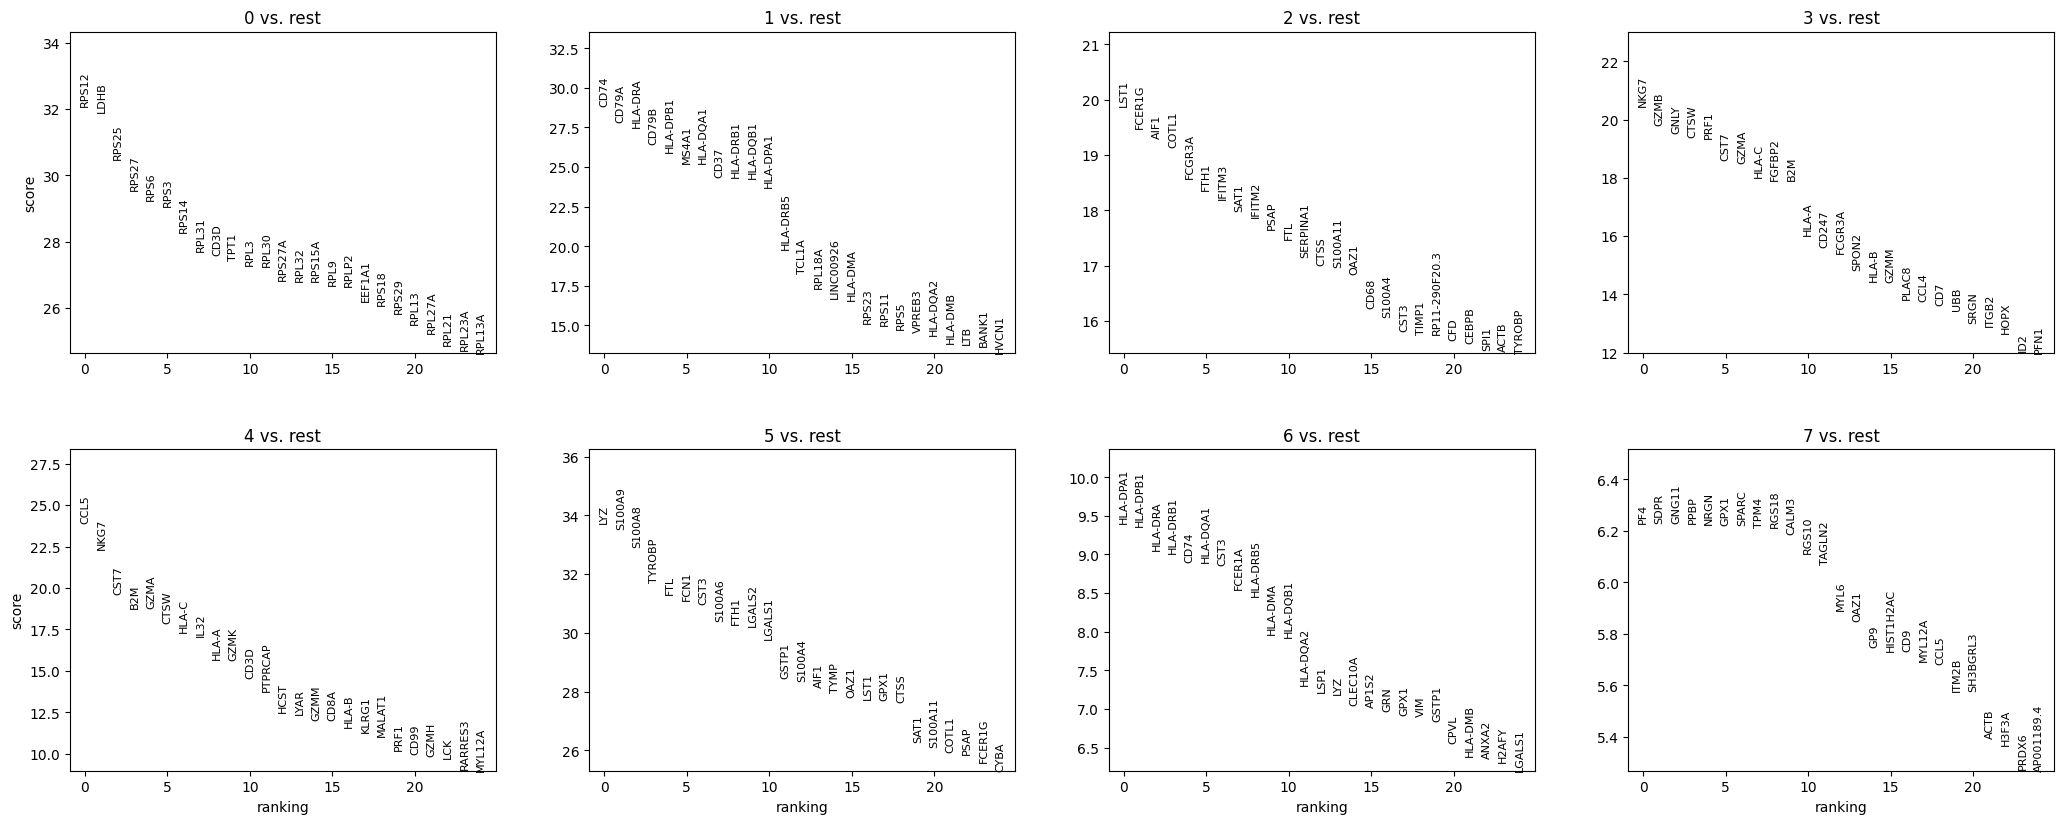

In [40]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

#### 🔘 Logreg Metodu

ranking genes
    finished (0:00:01)


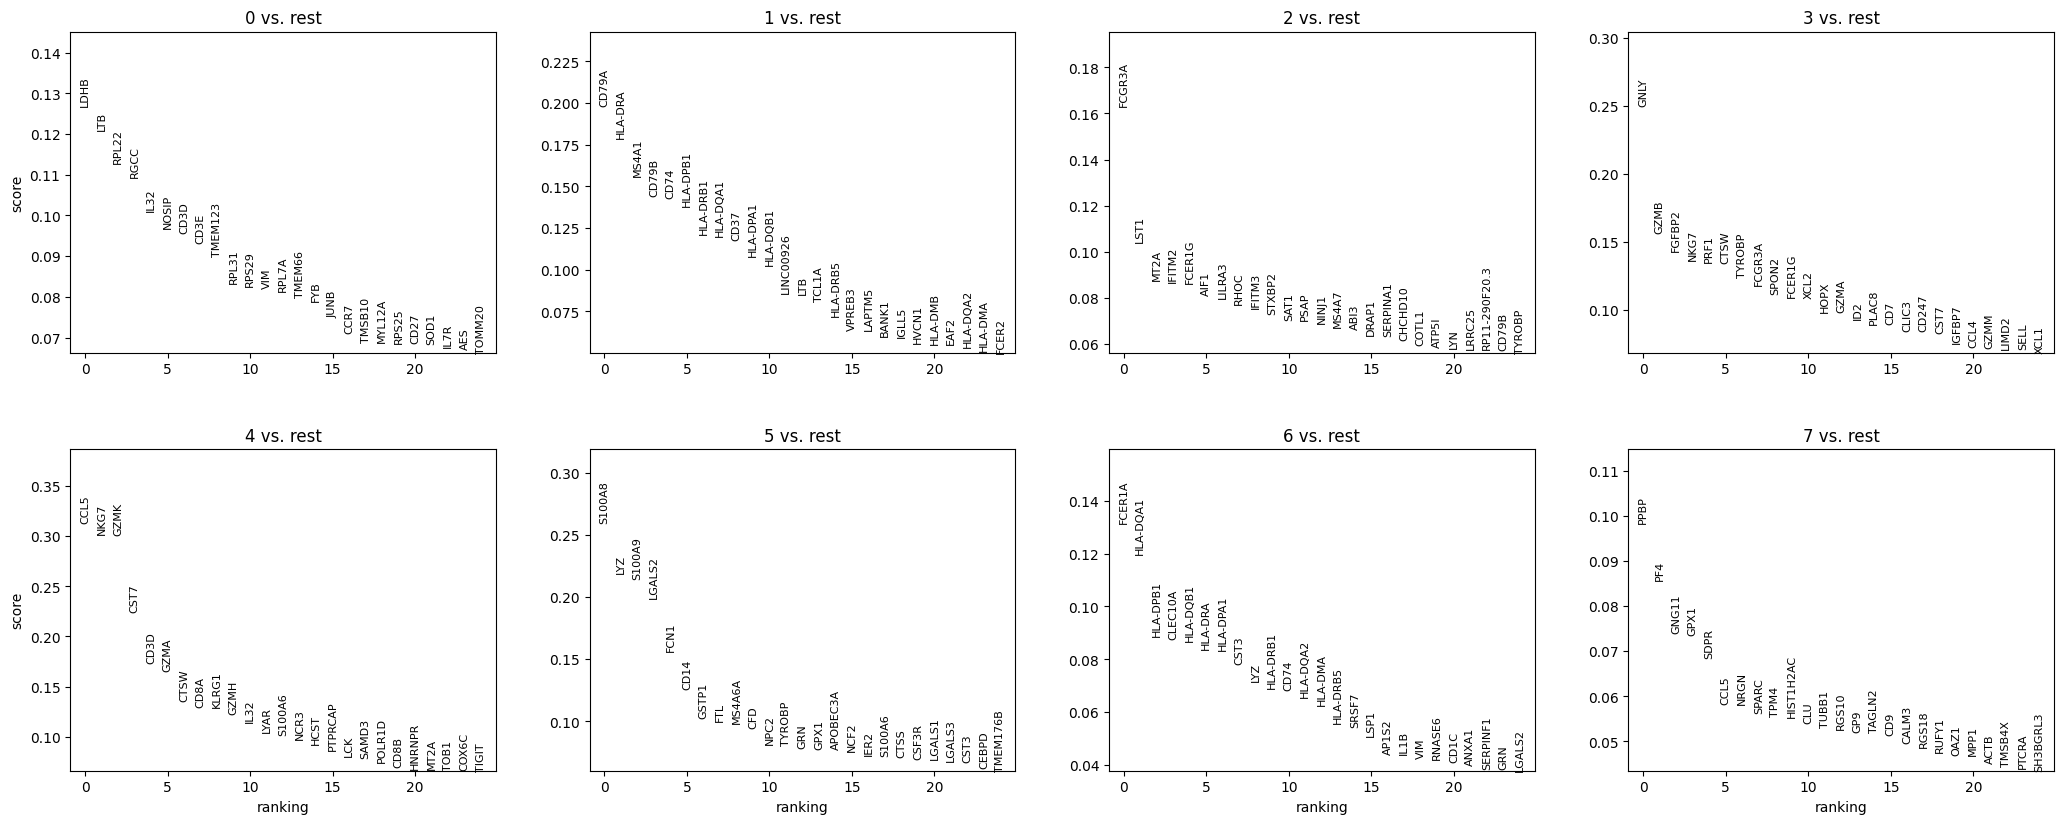

In [39]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Örnek bir referesans belirteç gen listesi oluşturalım:

In [41]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [42]:
adata# = sc.read(results_file)

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [43]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

0         1       2     3     4       5         6      7
0  RPS12      CD74    LST1  NKG7  CCL5     LYZ  HLA-DPA1    PF4
1   LDHB     CD79A  FCER1G  GZMB  NKG7  S100A9  HLA-DPB1   SDPR
2  RPS25   HLA-DRA    AIF1  GNLY  CST7  S100A8   HLA-DRA  GNG11
3  RPS27     CD79B   COTL1  CTSW   B2M  TYROBP  HLA-DRB1   PPBP
4   RPS6  HLA-DPB1  FCGR3A  PRF1  GZMA     FTL      CD74   NRGN

In [44]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

0_n            0_p       1_n            1_p     2_n           2_p   3_n  \
0  RPS12  4.167598e-226      CD74  2.487145e-183    LST1  4.985426e-88  NKG7   
1   LDHB  1.794807e-223     CD79A  1.679730e-170  FCER1G  1.449472e-84  GZMB   
2  RPS25  4.655800e-204   HLA-DRA  6.935111e-167    AIF1  5.833547e-83  GNLY   
3  RPS27  9.438482e-192     CD79B  2.569135e-154   COTL1  1.261406e-81  CTSW   
4   RPS6  5.767118e-188  HLA-DPB1  3.577195e-148  FCGR3A  4.610698e-77  PRF1   

            3_p   4_n            4_p     5_n            5_p       6_n  \
0  3.591782e-93  CCL5  4.062586e-126     LYZ  2.844372e-249  HLA-DPA1   
1  2.033412e-87  NKG7  1.528118e-110  S100A9  2.651928e-246  HLA-DPB1   
2  8.130223e-85  CST7   1.332168e-85  S100A8  8.731315e-238   HLA-DRA   
3  6.944632e-84   B2M   8.615108e-79  TYROBP  9.809633e-221  HLA-DRB1   
4  1.621421e-83  GZMA   1.480430e-78     FTL  3.676035e-215      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

#### 🔵 Diferansiyel Gen Ekspresyon Analizi

**`rank_genes_groups`** fonksiyonu, her genin `Leiden` kümeleri arasındaki diferansiyel gen ekspresyon (DGE) farklarını değerlendirir. Yani, her genin farklı hücre kümelerinde daha yüksek veya daha düşük ekspresyon gösterip göstermediği analiz edilir. Ardından, bu gen ekspresyon farklarının istatistiksel olarak anlamlı olup olmadığı `Wilcoxon` testi kullanılarak belirlenir. Bu şekilde, her bir hücre kümesi için belirgin ve biyolojik olarak anlamlı gen ekspresyon değişiklikleri tanımlanır.

ranking genes
    finished (0:00:00)


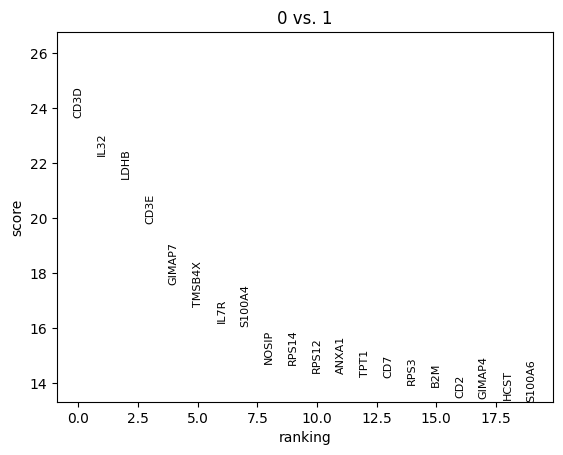

In [45]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

Grup 0'da bulunan hücrelerde en yüksek gen ekspresyon seviyesine sahip 8 genin violin grafik ile gösterilmiştir.

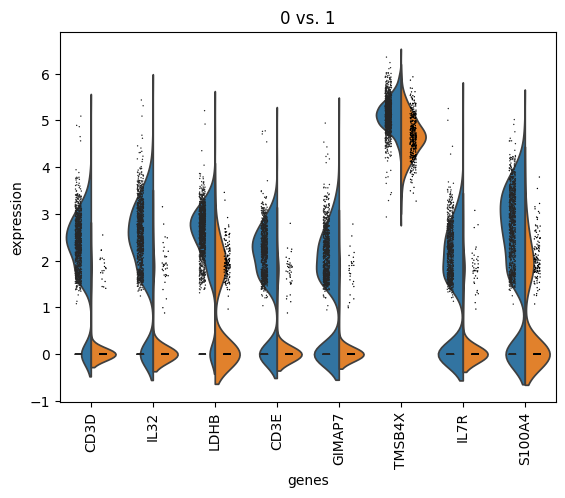

In [46]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

In [44]:
#adata = sc.read(results_file)

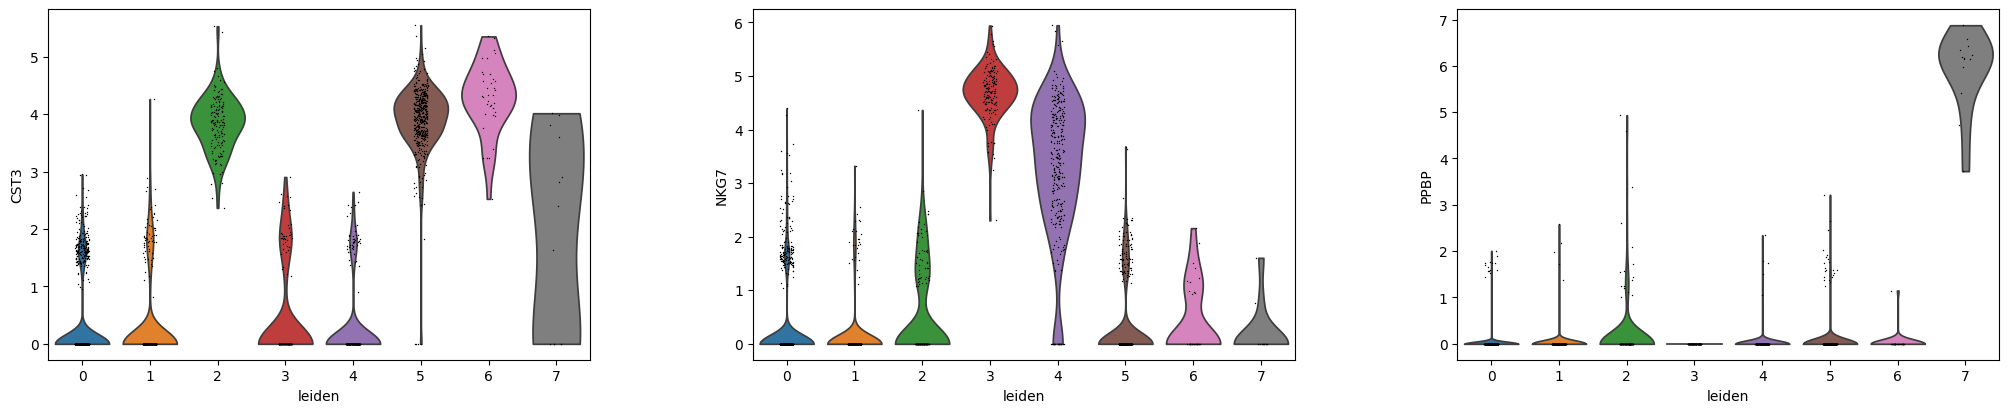

In [47]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

In [48]:
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


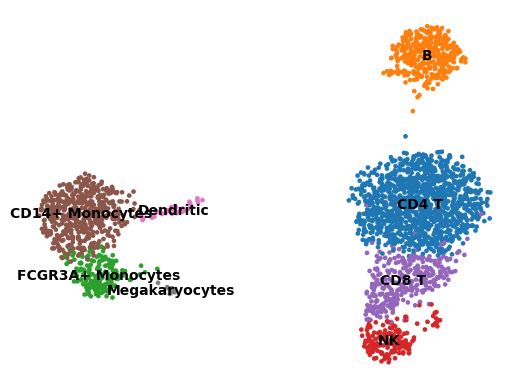

In [49]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

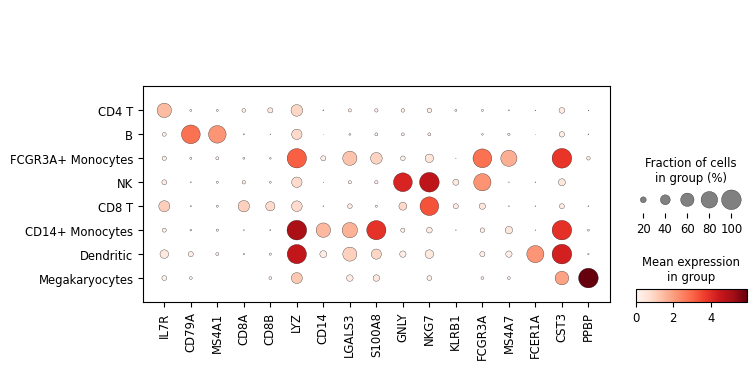

In [51]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden");

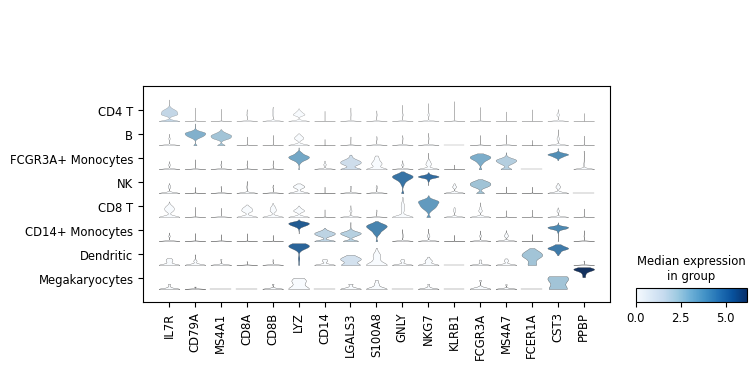

In [50]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");

Sonuçlarımızı `.h5ad`formatında kaydedelim:

In [51]:
adata.write("./BaskentUni_pbmc3k.h5ad", compression="gzip")

In [52]:
adata.raw.to_adata().write("./BaskentUni_pbmc3k_withoutX.h5ad") # 'path' kısmında sonuçları kaydedeceğiniz dizini belirtiniz.

## 🔶 Kaynakça
- [Scanpy Rehber](https://scanpy.readthedocs.io/en/stable/tutorials/)

- [Scanpy görselleştirme github](https://github.com/mousepixels/sanbomics_scripts/blob/main/Scanpy_intro_pp_clustering_markers.ipynb)

- [Seurat Rehber](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html)